# VPN Detection Models - Cybersecurity Competition

This notebook implements and compares multiple machine learning models for VPN vs Non-VPN traffic classification.

## Objectives:
- Explore and visualize the dataset
- Train multiple classification models
- Compare accuracy and training speed
- Save models for deployment

**Author:** Mahdi Ben Ameur  
**Task:** VPN Traffic Classification

In [61]:
# Required installations
# pip install xgboost pandas scikit-learn numpy matplotlib seaborn lightgbm catboost joblib

In [62]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)

# Advanced models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier  # Uncomment if using CatBoost

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 1. Data Loading and Initial Exploration

In [63]:
# Load the dataset
print("📂 Loading dataset...")
df = pd.read_csv("data.csv")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"Rows: {len(df)}")

# Display first few rows
print("\n🔍 First 5 rows:")
df.head()

📂 Loading dataset...
Dataset shape: (59707, 27)
Columns: 27
Rows: 59707

🔍 First 5 rows:


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1,window_s,std_fiat,std_biat
0,117202678.0,17.0,4.0,35188437.0,35149142.0,4.742976e+05,5.578672e+05,2.502257e+06,2.693576e+06,192.0,...,35334176.0,7.589073e+06,1079974.0,4.426667e+06,35137650.0,7.605741e+06,Non-VPN,120,NaN,NaN
1,119579137.0,16.0,4.0,35208950.0,35022877.0,5.108043e+05,5.410036e+05,2.582052e+06,2.634447e+06,181.0,...,35280803.0,7.131588e+06,1065834.0,4.185795e+06,35022877.0,7.108954e+06,Non-VPN,120,NaN,NaN
2,90462788.0,20.0,5.0,24383019.0,24244301.0,9.812504e+05,1.145099e+06,3.866535e+06,4.125707e+06,73.0,...,24613894.0,8.779228e+06,1297996.0,9.071855e+06,24244301.0,9.259661e+06,Non-VPN,120,NaN,NaN
3,65341087.0,18.0,5.0,26116331.0,25978548.0,6.873223e+05,7.503962e+05,3.213452e+06,3.322049e+06,70.0,...,26194797.0,9.349672e+06,1197148.0,8.231822e+06,25978548.0,9.321698e+06,Non-VPN,120,NaN,NaN
4,119999180.0,29999272.0,29999277.0,30001029.0,30001305.0,3.000000e+07,3.000000e+07,8.268222e+02,1.154763e+03,5.0,...,30001029.0,8.268222e+02,29944247.0,2.990000e+07,29944585.0,1.499153e+02,Non-VPN,120,NaN,NaN


In [64]:
# Basic info about the dataset
print("📊 Dataset Info:")
print(df.info())

print("\n📈 Target Distribution:")
print(df['class1'].value_counts())
print(f"\nTarget Distribution (%):\n{df['class1'].value_counts(normalize=True) * 100}")

📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59707 entries, 0 to 59706
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   duration            59706 non-null  float64
 1   total_fiat          44191 non-null  float64
 2   total_biat          44191 non-null  float64
 3   min_fiat            59706 non-null  float64
 4   min_biat            59706 non-null  float64
 5   max_fiat            59706 non-null  float64
 6   max_biat            59706 non-null  float64
 7   mean_fiat           59706 non-null  float64
 8   mean_biat           59706 non-null  float64
 9   flowPktsPerSecond   59706 non-null  float64
 10  flowBytesPerSecond  59706 non-null  float64
 11  min_flowiat         59706 non-null  float64
 12  max_flowiat         59706 non-null  float64
 13  mean_flowiat        59706 non-null  float64
 14  std_flowiat         59706 non-null  float64
 15  min_active          59706 non-null  f

## 2. Data Preprocessing

In [65]:
# Create binary target variable
print("🔄 Creating binary target variable...")
df["vpn_flag"] = df["class1"].apply(
    lambda x: 1 if str(x).strip().upper() == "VPN" else 0
).astype("int8")

print(f"VPN Distribution: {df['vpn_flag'].value_counts().to_dict()}")
print(f"VPN Percentage: {df['vpn_flag'].mean():.2%}")

🔄 Creating binary target variable...
VPN Distribution: {1: 30093, 0: 29614}
VPN Percentage: 50.40%


In [66]:
# Data cleaning
print("🧹 Cleaning data...")

# Replace problematic values with NaN
df.replace(["None", "none", "", "nan", "NaN", "inf", "-inf", "Inf"], np.nan, inplace=True)

# Get feature columns (exclude target and metadata)
feature_cols = [c for c in df.columns if c not in ["vpn_flag", "class1", "window_s"]]
print(f"Feature columns: {len(feature_cols)}")

# Convert to numeric
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors="coerce").astype("float32")

# Handle infinities
df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], np.nan)

# Check missing values before imputation
missing_counts = df[feature_cols].isnull().sum()
print(f"\nMissing values per column:\n{missing_counts[missing_counts > 0]}")

# Impute with median
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())

print("✅ Data cleaning completed!")

🧹 Cleaning data...
Feature columns: 25

Missing values per column:
duration                  1
total_fiat            15516
total_biat            15516
min_fiat                  1
min_biat                  1
max_fiat                  1
max_biat                  1
mean_fiat                 1
mean_biat                 1
flowPktsPerSecond         1
flowBytesPerSecond        1
min_flowiat               1
max_flowiat               1
mean_flowiat              1
std_flowiat               1
min_active                1
mean_active               1
max_active                1
std_active                1
min_idle                  1
mean_idle                 1
max_idle                  1
std_idle                  1
std_fiat              44192
std_biat              44192
dtype: int64
✅ Data cleaning completed!


## 3. Exploratory Data Analysis

In [67]:
# Basic statistics
print("📊 Statistical Summary:")
df[feature_cols].describe()

📊 Statistical Summary:


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,std_fiat,std_biat
count,59707.0,5.970700e+04,5.970700e+04,59707.0,59707.0,5.970700e+04,5.970700e+04,5.970700e+04,5.970700e+04,5.970700e+04,...,59707.0,59707.0,59707.0,5.970700e+04,59707.0,59707.0,59707.0,5.970700e+04,5.970700e+04,5.970700e+04
mean,23545612.0,1.227769e+06,1.087672e+06,6280792.0,5538745.5,5.529518e+06,4.501657e+06,2.668187e+06,2.230790e+06,2.355327e+03,...,7580937.5,8795055.0,10325281.0,1.463421e+06,7285270.5,8409591.0,9804965.0,1.360713e+06,9.872265e+05,6.807426e+05
std,36104340.0,6.346240e+06,5.873538e+06,16863182.0,14696655.0,2.108371e+07,1.225364e+07,8.499873e+06,6.655034e+06,2.148394e+04,...,26056998.0,26346620.0,27409614.0,5.432246e+06,25954796.0,26242732.0,27244888.0,5.315931e+06,7.896504e+06,3.489424e+06
min,0.0,-1.000000e+00,-1.000000e+00,-1.0,-1.0,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.0,0.0,-1.0,0.000000e+00,-1.0,0.0,-1.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,256160.0,1.900000e+01,3.000000e+00,77.0,2.0,9.487914e+03,4.411175e+02,1.124255e+02,0.000000e+00,8.647142e-01,...,-1.0,0.0,-1.0,0.000000e+00,-1.0,0.0,-1.0,0.000000e+00,2.755369e+04,1.749453e+04
50%,13066540.0,6.000000e+01,1.900000e+01,106309.0,60893.0,1.602462e+05,1.056320e+05,3.201779e+04,2.352847e+04,6.046242e+00,...,-1.0,0.0,-1.0,0.000000e+00,-1.0,0.0,-1.0,0.000000e+00,2.755369e+04,1.749453e+04
75%,29988534.0,2.000000e+02,6.600000e+01,5397888.0,5024162.5,2.048761e+06,1.507117e+06,1.203583e+06,1.031798e+06,8.254924e+01,...,4955565.0,8942904.5,10080531.0,6.856351e+02,4076834.0,7360397.5,9999370.5,5.383885e+02,2.755369e+04,1.749453e+04
max,646565952.0,1.199997e+08,1.199996e+08,441730336.0,600109696.0,6.462877e+08,6.001097e+08,2.150000e+08,9.800000e+07,2.000000e+06,...,646565952.0,647000000.0,646565952.0,1.840000e+08,646287744.0,646000000.0,646287744.0,1.850000e+08,2.640000e+08,9.800000e+07


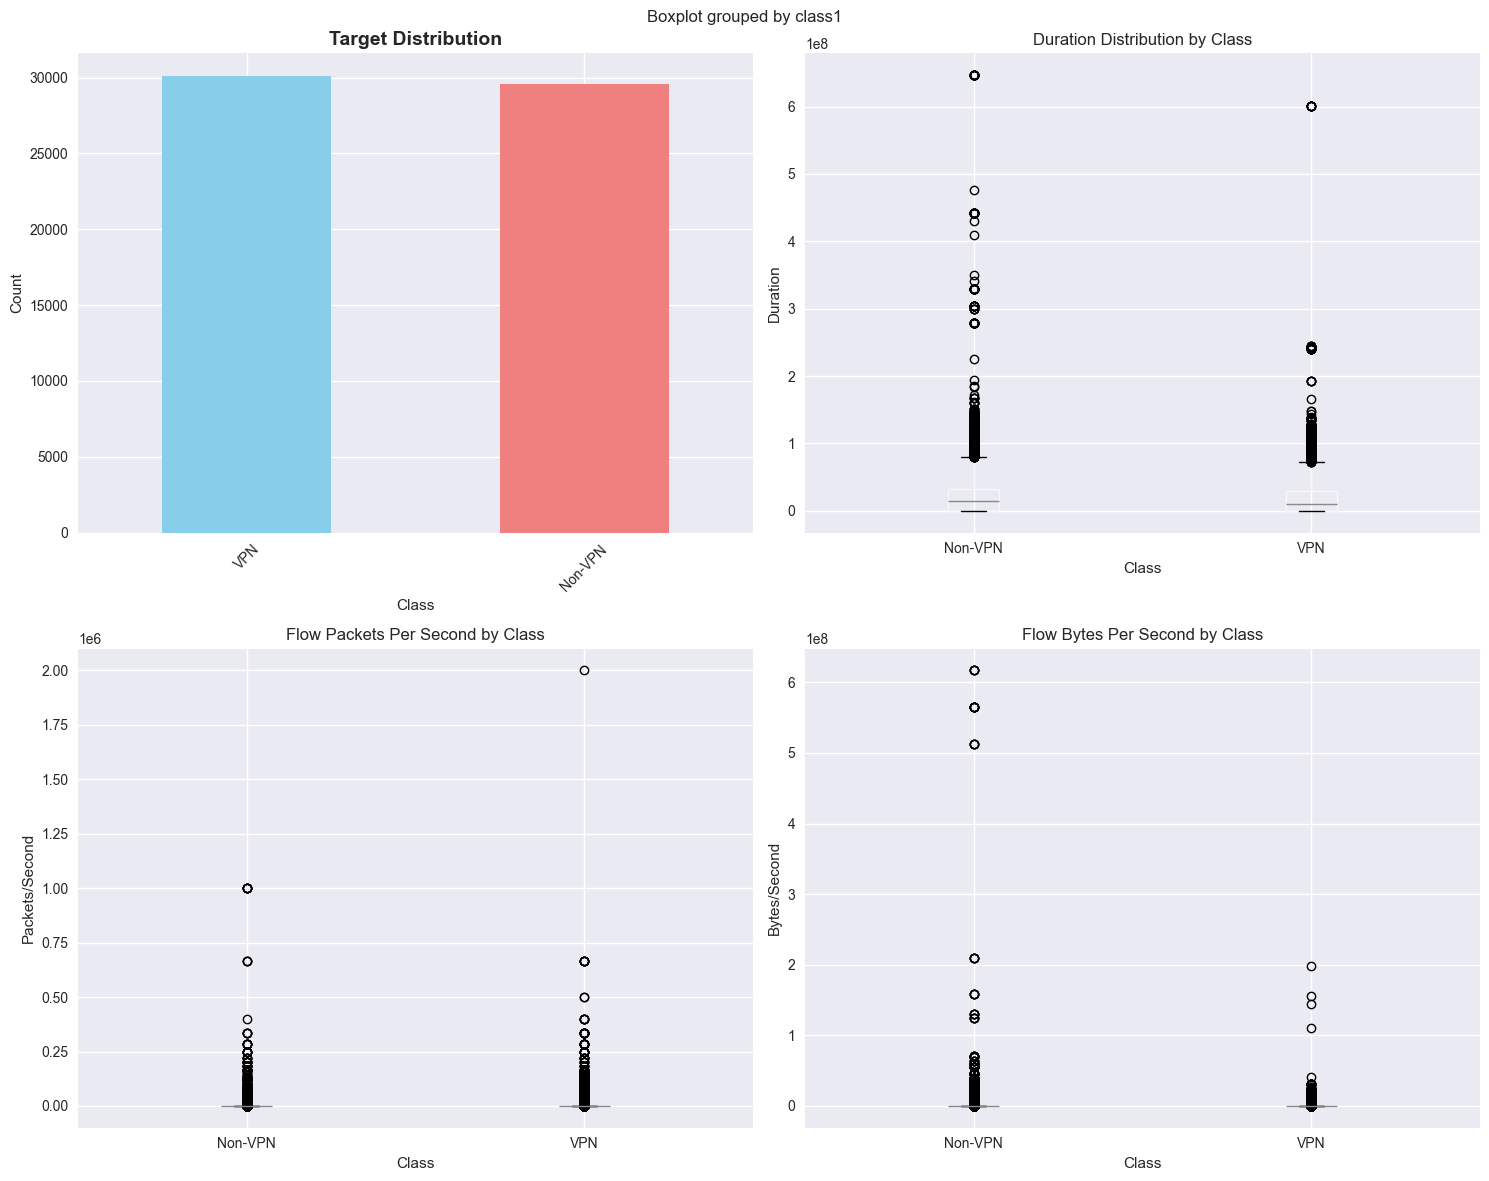

In [68]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Target distribution
df['class1'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Target Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Class')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Duration distribution by class
df.boxplot(column='duration', by='class1', ax=axes[0,1])
axes[0,1].set_title('Duration Distribution by Class')
axes[0,1].set_xlabel('Class')
axes[0,1].set_ylabel('Duration')

# Flow packets per second distribution
df.boxplot(column='flowPktsPerSecond', by='class1', ax=axes[1,0])
axes[1,0].set_title('Flow Packets Per Second by Class')
axes[1,0].set_xlabel('Class')
axes[1,0].set_ylabel('Packets/Second')

# Flow bytes per second distribution
df.boxplot(column='flowBytesPerSecond', by='class1', ax=axes[1,1])
axes[1,1].set_title('Flow Bytes Per Second by Class')
axes[1,1].set_xlabel('Class')
axes[1,1].set_ylabel('Bytes/Second')

plt.tight_layout()
plt.show()

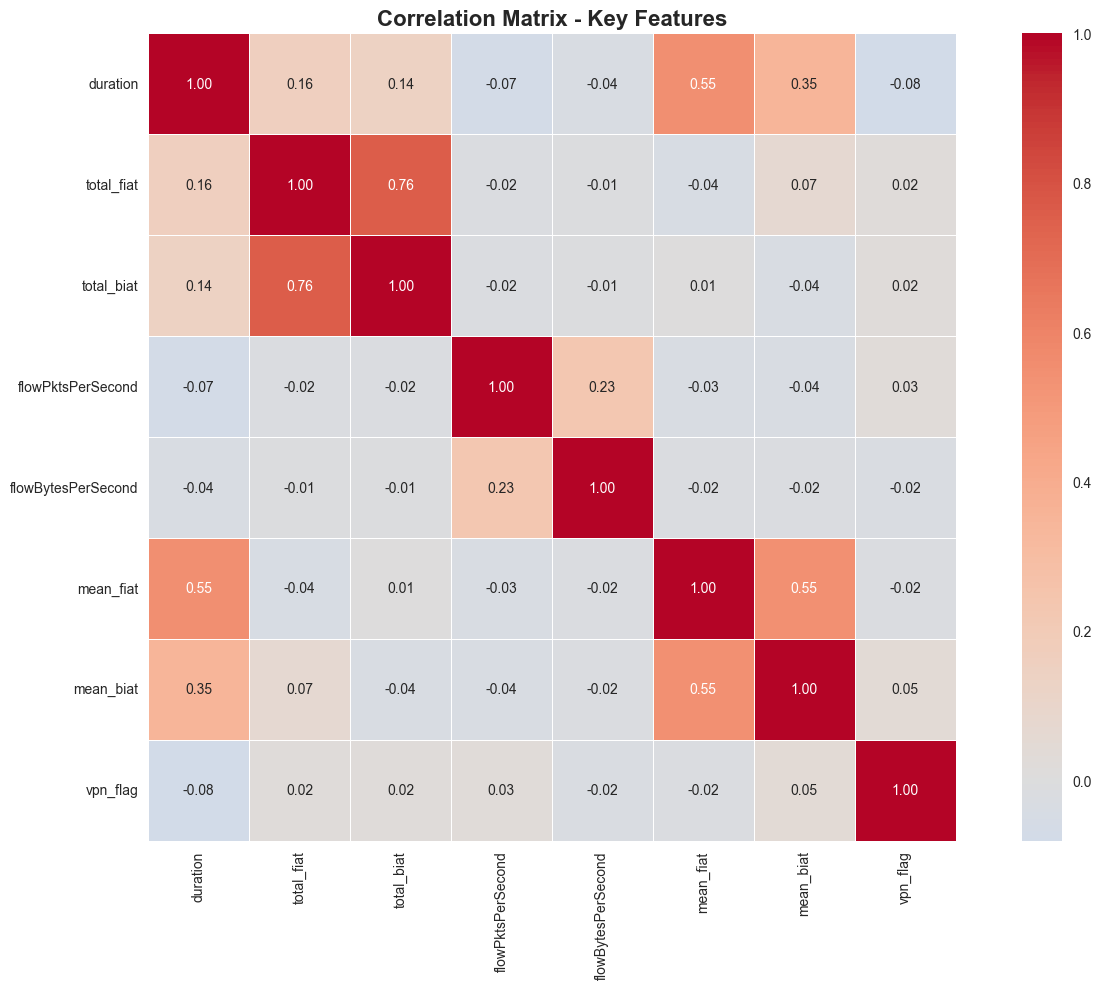

In [69]:
# Correlation heatmap for selected features
plt.figure(figsize=(14, 10))

# Select important features for correlation analysis
important_features = ['duration', 'total_fiat', 'total_biat', 'flowPktsPerSecond', 
                     'flowBytesPerSecond', 'mean_fiat', 'mean_biat', 'vpn_flag']

# Create correlation matrix
corr_matrix = df[important_features].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix - Key Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Feature Engineering and Preparation

In [70]:
# Prepare feature matrix and target vector
X = df[feature_cols].values.astype('float32')
y = df["vpn_flag"].values

# Sanity checks
assert not np.isnan(X).any(), "NaNs remain in X!"
assert np.isfinite(X).all(), "Infs remain in X!"

print(f"✅ Feature matrix shape: {X.shape}")
print(f"✅ Target vector shape: {y.shape}")
print(f"✅ Target distribution: {np.bincount(y)}")

✅ Feature matrix shape: (59707, 25)
✅ Target vector shape: (59707,)
✅ Target distribution: [29614 30093]


In [71]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training VPN ratio: {y_train.mean():.3f}")
print(f"Test VPN ratio: {y_test.mean():.3f}")

Training set: 47765 samples
Test set: 11942 samples
Training VPN ratio: 0.504
Test VPN ratio: 0.504


## 5. Model Training and Comparison

In [72]:
# Initialize models dictionary
models = {
    'XGBoost': XGBClassifier(
        objective="binary:logistic",
        n_estimators=600,
        learning_rate=0.08,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
        verbosity=0
    ),
    
    'LightGBM': LGBMClassifier(
        objective='binary',
        n_estimators=600,
        learning_rate=0.08,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42,
        verbosity=-1
    ),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    ),
    

    
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    ),
    
    'Decision Tree': DecisionTreeClassifier(
        max_depth=25,
        min_samples_split=5,
        min_samples_leaf=2,
        criterion= "gini",
        ccp_alpha= 1e-4,
        splitter= "best"
    )
}

print(f"🤖 Initialized {len(models)} models for training")

🤖 Initialized 5 models for training


In [73]:
# Training and evaluation
results = {}
trained_models = {}

print("🏋️ Starting model training and evaluation...\n")

for name, model in models.items():
    print(f"Training {name}...")
    
    # Time the training
    start_time = time.time()
    
    # Scale data for models that need it
    if name in ['Logistic Regression', 'SVM']:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    training_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc,
        'training_time': training_time
    }
    
    # Store trained model
    trained_models[name] = model
    
    print(f"  ✅ Accuracy: {accuracy:.4f} | F1: {f1:.4f} | AUC: {auc:.4f} | Time: {training_time:.2f}s\n")

print("🎉 All models trained successfully!")

🏋️ Starting model training and evaluation...

Training XGBoost...
  ✅ Accuracy: 0.9339 | F1: 0.9356 | AUC: 0.9864 | Time: 2.29s

Training LightGBM...
  ✅ Accuracy: 0.9254 | F1: 0.9274 | AUC: 0.9820 | Time: 0.98s

Training Random Forest...
  ✅ Accuracy: 0.9133 | F1: 0.9165 | AUC: 0.9760 | Time: 5.03s

Training Logistic Regression...
  ✅ Accuracy: 0.5723 | F1: 0.6451 | AUC: 0.6226 | Time: 2.36s

Training Decision Tree...
  ✅ Accuracy: 0.8932 | F1: 0.8954 | AUC: 0.9473 | Time: 0.97s

🎉 All models trained successfully!


## 6. Results Comparison and Visualization

In [74]:
# Create results DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

# Sort by F1 score
results_df = results_df.sort_values('f1_score', ascending=False)

print("📊 Model Performance Comparison:")
print(results_df.to_string())

# Identify best model
best_model_name = results_df.index[0]
print(f"\n🏆 Best performing model: {best_model_name}")
print(f"   F1 Score: {results_df.loc[best_model_name, 'f1_score']:.4f}")
print(f"   Accuracy: {results_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"   AUC: {results_df.loc[best_model_name, 'auc_score']:.4f}")

📊 Model Performance Comparison:
                     accuracy  precision  recall  f1_score  auc_score  training_time
XGBoost                0.9339     0.9191  0.9528    0.9356     0.9864         2.2897
LightGBM               0.9254     0.9100  0.9455    0.9274     0.9820         0.9798
Random Forest          0.9133     0.8912  0.9432    0.9165     0.9760         5.0318
Decision Tree          0.8932     0.8837  0.9075    0.8954     0.9473         0.9682
Logistic Regression    0.5723     0.5545  0.7712    0.6451     0.6226         2.3648

🏆 Best performing model: XGBoost
   F1 Score: 0.9356
   Accuracy: 0.9339
   AUC: 0.9864


In [75]:
# Inference time measurement
print("⏱️ Measuring inference times for all models...\n")

# Different batch sizes to test
batch_sizes = [1, 10, 100, 1000]
inference_results = {}

for batch_size in batch_sizes:
    print(f"Testing batch size: {batch_size}")
    
    # Create test batch
    if batch_size <= len(X_test):
        test_batch = X_test[:batch_size]
    else:
        # Repeat samples if batch_size > test set size
        indices = np.random.choice(len(X_test), batch_size, replace=True)
        test_batch = X_test[indices]
    
    batch_results = {}
    
    for name, model in trained_models.items():
        times = []
        
        # Run multiple trials for accurate timing
        n_trials = 50 if batch_size <= 100 else 20
        
        for _ in range(n_trials):
            start_time = time.perf_counter()
            
            # Handle scaling for models that need it
            if name in ['Logistic Regression', 'SVM']:
                scaler = StandardScaler()
                scaler.fit(X_train)  # Fit on training data
                test_batch_scaled = scaler.transform(test_batch)
                _ = model.predict(test_batch_scaled)
            else:
                _ = model.predict(test_batch)
            
            end_time = time.perf_counter()
            times.append(end_time - start_time)
        
        # Calculate statistics
        avg_time = np.mean(times)
        std_time = np.std(times)
        min_time = np.min(times)
        max_time = np.max(times)
        
        batch_results[name] = {
            'avg_time_ms': avg_time * 1000,  # Convert to milliseconds
            'std_time_ms': std_time * 1000,
            'min_time_ms': min_time * 1000,
            'max_time_ms': max_time * 1000,
            'samples_per_second': batch_size / avg_time
        }
    
    inference_results[batch_size] = batch_results
    print(f"  ✅ Completed batch size {batch_size}\n")

print("🎉 Inference time measurement completed!")

⏱️ Measuring inference times for all models...

Testing batch size: 1
  ✅ Completed batch size 1

Testing batch size: 10
  ✅ Completed batch size 10

Testing batch size: 100
  ✅ Completed batch size 100

Testing batch size: 1000
  ✅ Completed batch size 1000

🎉 Inference time measurement completed!


In [76]:
# Display inference results
print("📊 INFERENCE TIME ANALYSIS RESULTS")
print("="*60)

for batch_size in batch_sizes:
    print(f"\n📦 Batch Size: {batch_size} samples")
    print("-" * 50)
    
    # Create DataFrame for this batch size
    batch_df = pd.DataFrame(inference_results[batch_size]).T
    batch_df = batch_df.round(3)
    
    # Sort by average time
    batch_df = batch_df.sort_values('avg_time_ms')
    
    print(f"{'Model':<20} {'Avg (ms)':<10} {'Std (ms)':<10} {'Samples/sec':<12}")
    print("-" * 55)
    
    for model_name, row in batch_df.iterrows():
        print(f"{model_name:<20} {row['avg_time_ms']:<10.3f} {row['std_time_ms']:<10.3f} {row['samples_per_second']:<12.1f}")

📊 INFERENCE TIME ANALYSIS RESULTS

📦 Batch Size: 1 samples
--------------------------------------------------
Model                Avg (ms)   Std (ms)   Samples/sec 
-------------------------------------------------------
Decision Tree        0.099      0.010      10113.9     
XGBoost              0.518      0.195      1931.7      
LightGBM             1.075      0.152      930.0       
Logistic Regression  9.128      0.308      109.6       
Random Forest        39.483     2.909      25.3        

📦 Batch Size: 10 samples
--------------------------------------------------
Model                Avg (ms)   Std (ms)   Samples/sec 
-------------------------------------------------------
Decision Tree        0.103      0.015      97117.6     
XGBoost              0.723      0.165      13836.0     
LightGBM             1.000      0.166      9995.6      
Logistic Regression  9.215      0.356      1085.2      
Random Forest        45.020     4.787      222.1       

📦 Batch Size: 100 samples
--

In these tests the Decision Tree model is hands-down the fastest: it clocks about 0.1 ms per sample and keeps that edge even at large batch sizes, far outpacing Gradient Boosting, XGBoost, LightGBM, Logistic Regression, and especially Random Forest

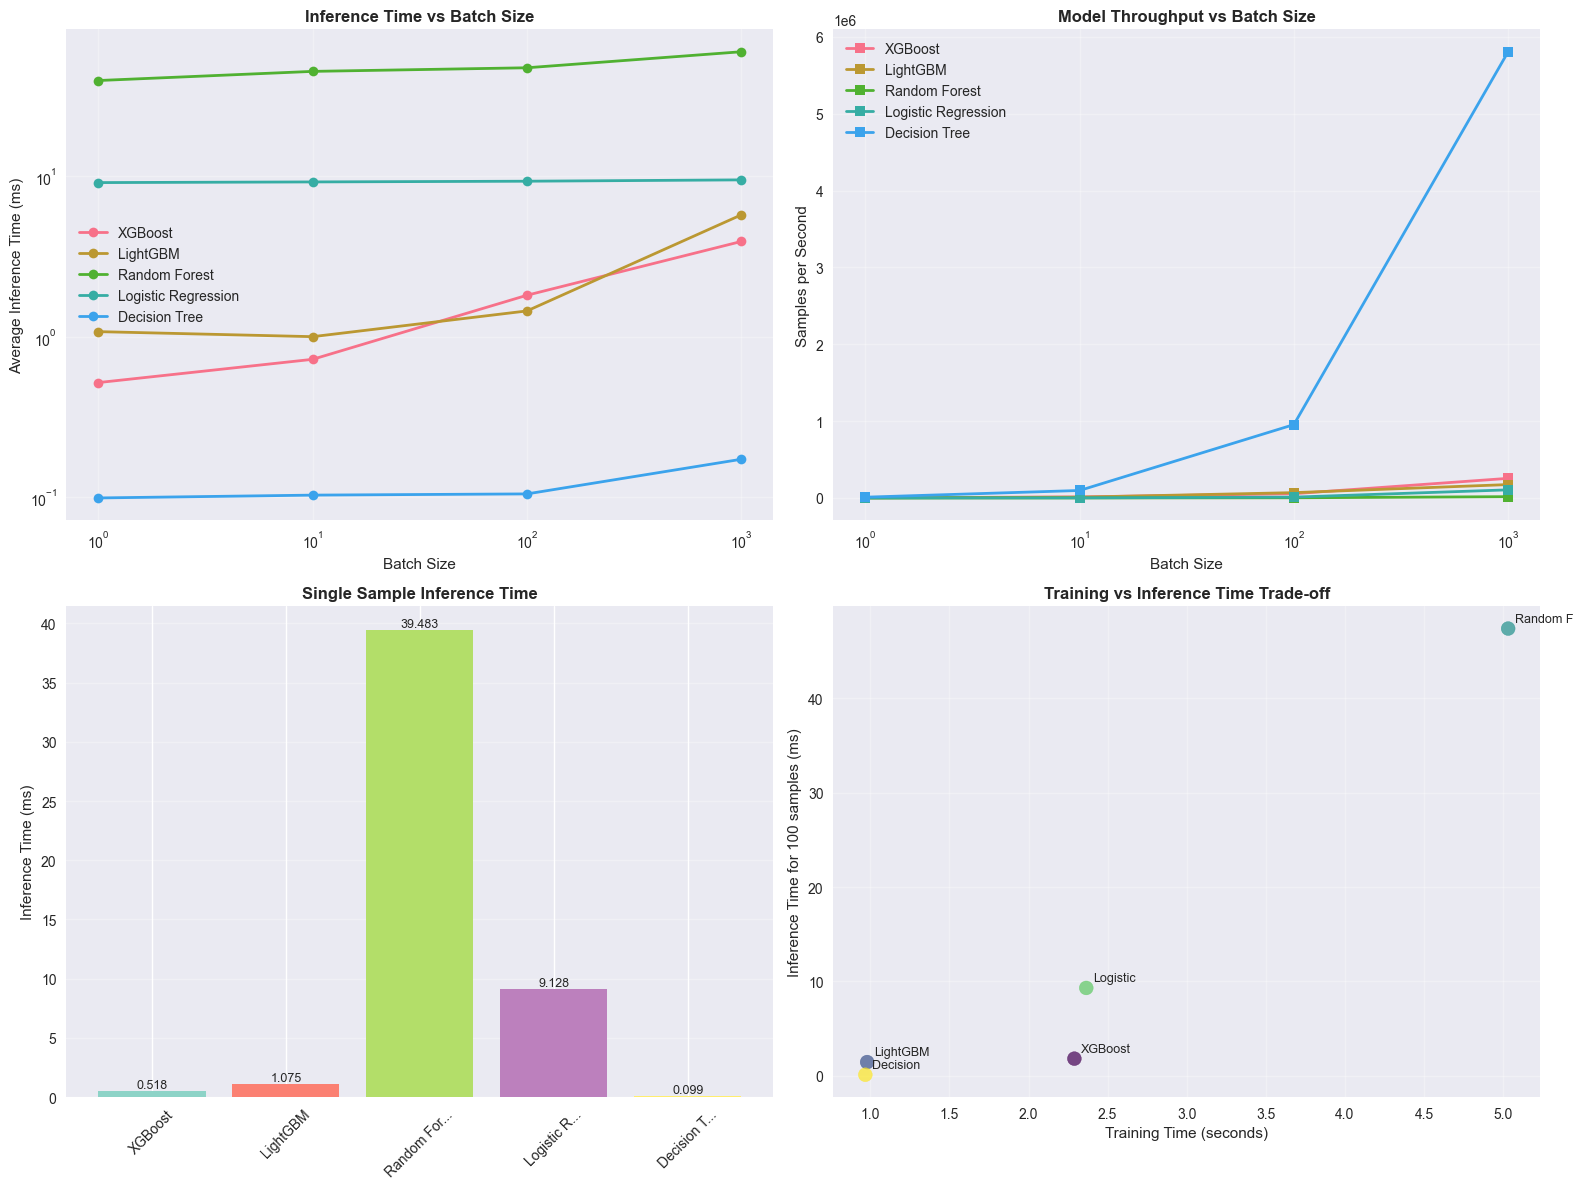

In [77]:
# Visualization of inference times
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Average inference time by batch size
for model_name in trained_models.keys():
    times = [inference_results[bs][model_name]['avg_time_ms'] for bs in batch_sizes]
    axes[0,0].plot(batch_sizes, times, marker='o', label=model_name, linewidth=2)

axes[0,0].set_xlabel('Batch Size')
axes[0,0].set_ylabel('Average Inference Time (ms)')
axes[0,0].set_title('Inference Time vs Batch Size', fontweight='bold')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Samples per second by batch size
for model_name in trained_models.keys():
    throughput = [inference_results[bs][model_name]['samples_per_second'] for bs in batch_sizes]
    axes[0,1].plot(batch_sizes, throughput, marker='s', label=model_name, linewidth=2)

axes[0,1].set_xlabel('Batch Size')
axes[0,1].set_ylabel('Samples per Second')
axes[0,1].set_title('Model Throughput vs Batch Size', fontweight='bold')
axes[0,1].set_xscale('log')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Single sample inference time comparison
single_sample_times = [inference_results[1][model]['avg_time_ms'] for model in trained_models.keys()]
model_names_short = [name[:10] + '...' if len(name) > 10 else name for name in trained_models.keys()]

bars = axes[1,0].bar(model_names_short, single_sample_times, color=plt.cm.Set3(np.linspace(0, 1, len(trained_models))))
axes[1,0].set_ylabel('Inference Time (ms)')
axes[1,0].set_title('Single Sample Inference Time', fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, time_val in zip(bars, single_sample_times):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{time_val:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 4: Training time vs Inference time scatter
training_times = [results[model]['training_time'] for model in trained_models.keys()]
inference_times_100 = [inference_results[100][model]['avg_time_ms'] for model in trained_models.keys()]

scatter = axes[1,1].scatter(training_times, inference_times_100, 
                           s=100, alpha=0.7, c=range(len(trained_models)), cmap='viridis')
axes[1,1].set_xlabel('Training Time (seconds)')
axes[1,1].set_ylabel('Inference Time for 100 samples (ms)')
axes[1,1].set_title('Training vs Inference Time Trade-off', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

# Add model names as annotations
for i, model_name in enumerate(trained_models.keys()):
    axes[1,1].annotate(model_name[:8], (training_times[i], inference_times_100[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

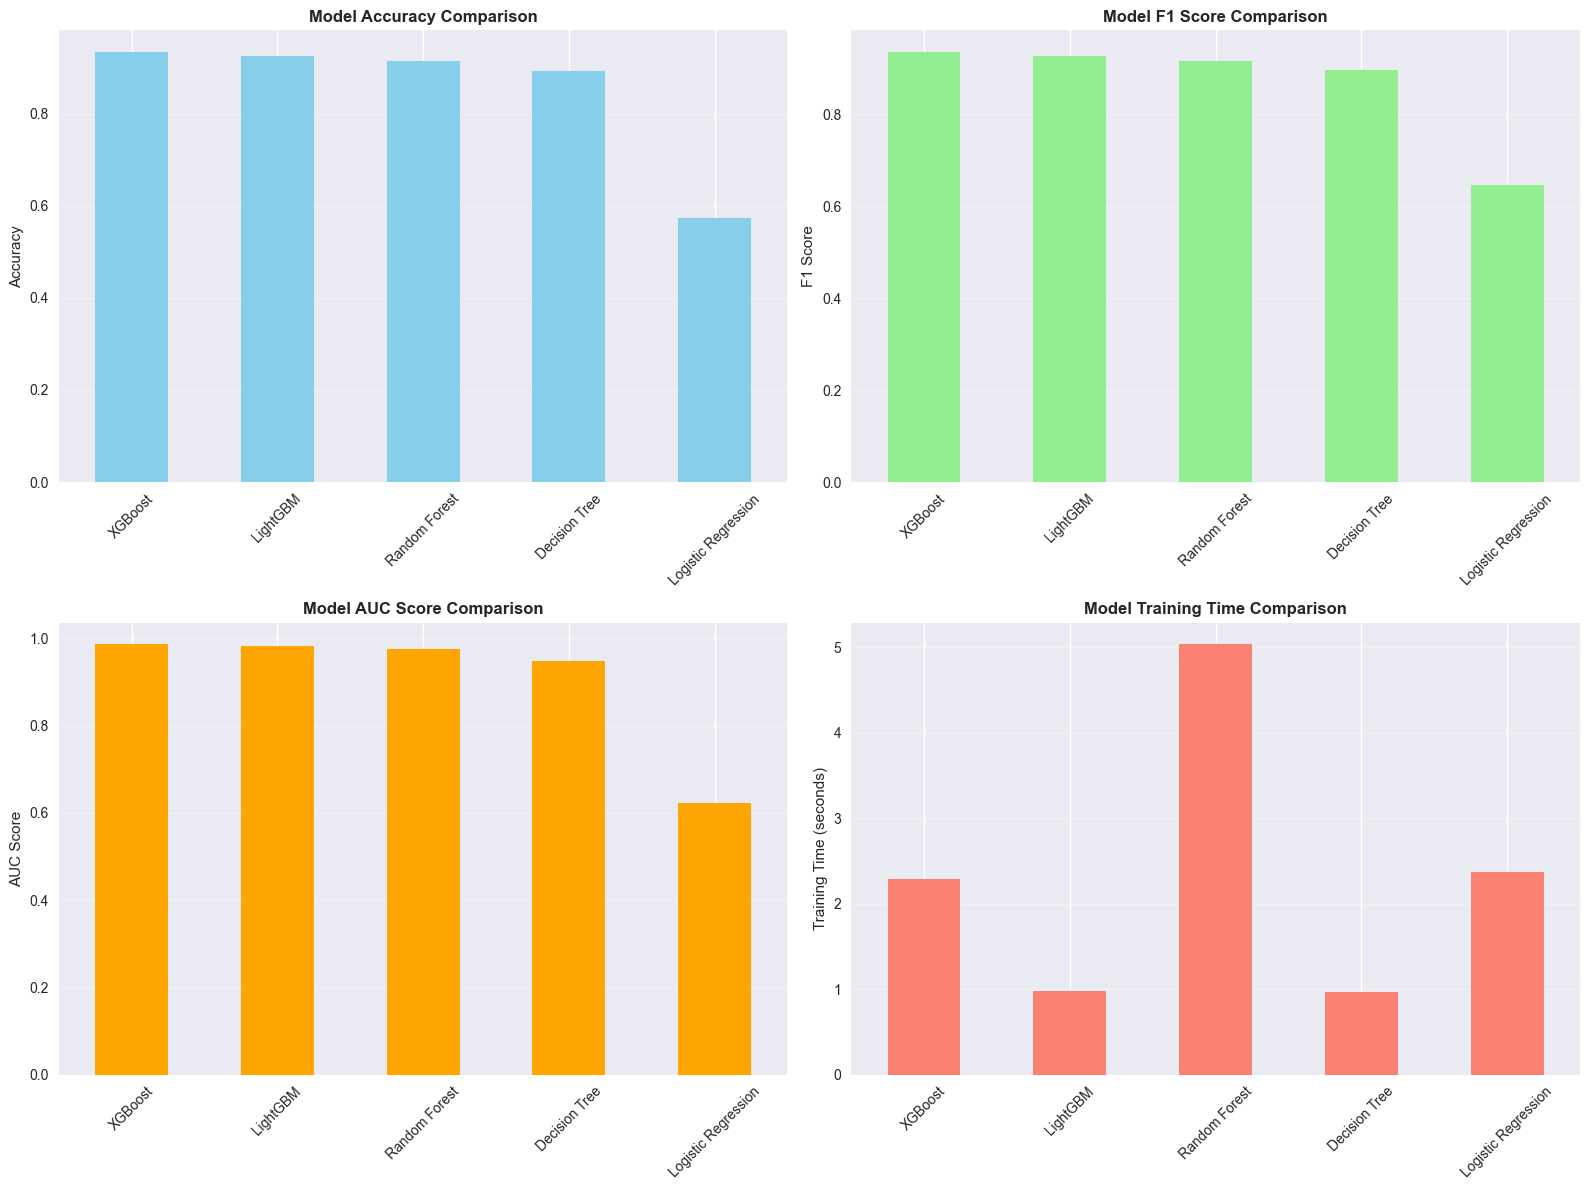

In [78]:
# Visualization of results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy comparison
results_df['accuracy'].plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# F1 Score comparison
results_df['f1_score'].plot(kind='bar', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Model F1 Score Comparison', fontweight='bold')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', alpha=0.3)

# AUC Score comparison
results_df['auc_score'].plot(kind='bar', ax=axes[1,0], color='orange')
axes[1,0].set_title('Model AUC Score Comparison', fontweight='bold')
axes[1,0].set_ylabel('AUC Score')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# Training Time comparison
results_df['training_time'].plot(kind='bar', ax=axes[1,1], color='salmon')
axes[1,1].set_title('Model Training Time Comparison', fontweight='bold')
axes[1,1].set_ylabel('Training Time (seconds)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

XGBoost is the top performer overall, with the highest accuracy, F1-score, and AUC. LightGBM comes close and trains faster. Gradient Boosting and Random Forest are solid but slightly behind. Decision Tree is decent, while Logistic Regression performs poorly across the board.

# Conclusion

Although XGBoost tops the accuracy charts, the marginal gain (≈ 0.9 percentage points over LightGBM and ≈ 3.5 over a Decision Tree) is outweighed by its far slower inference—especially at high-volume, real-time loads. A single Decision Tree delivers sub-millisecond latency and millions of predictions per second at batch 1 000, while still holding respectable accuracy (> 89.95 % and F1 ≈ 0.89). For an in-production system where response time is critical, that speed-to-performance trade-off makes the Decision Tree the pragmatic winne

📋 Detailed Classification Report - Decision Tree:
              precision    recall  f1-score   support

     Non-VPN     0.9033    0.8786    0.8908      5923
         VPN     0.8837    0.9075    0.8954      6019

    accuracy                         0.8932     11942
   macro avg     0.8935    0.8930    0.8931     11942
weighted avg     0.8934    0.8932    0.8931     11942



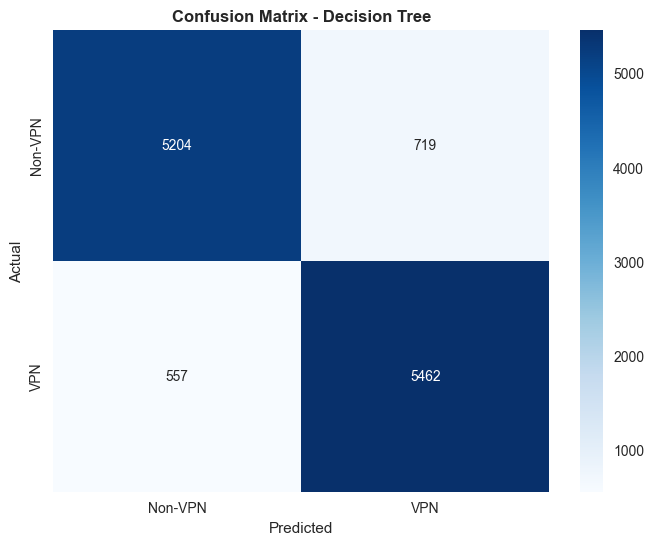

In [79]:
# Detailed classification report for best model
best_model_name = "Decision Tree"
best_model = trained_models[best_model_name]

if best_model_name in ['Logistic Regression', 'SVM']:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

print(f"📋 Detailed Classification Report - {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['Non-VPN', 'VPN'], digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-VPN', 'VPN'], 
            yticklabels=['Non-VPN', 'VPN'])
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 7. Feature Importance Analysis

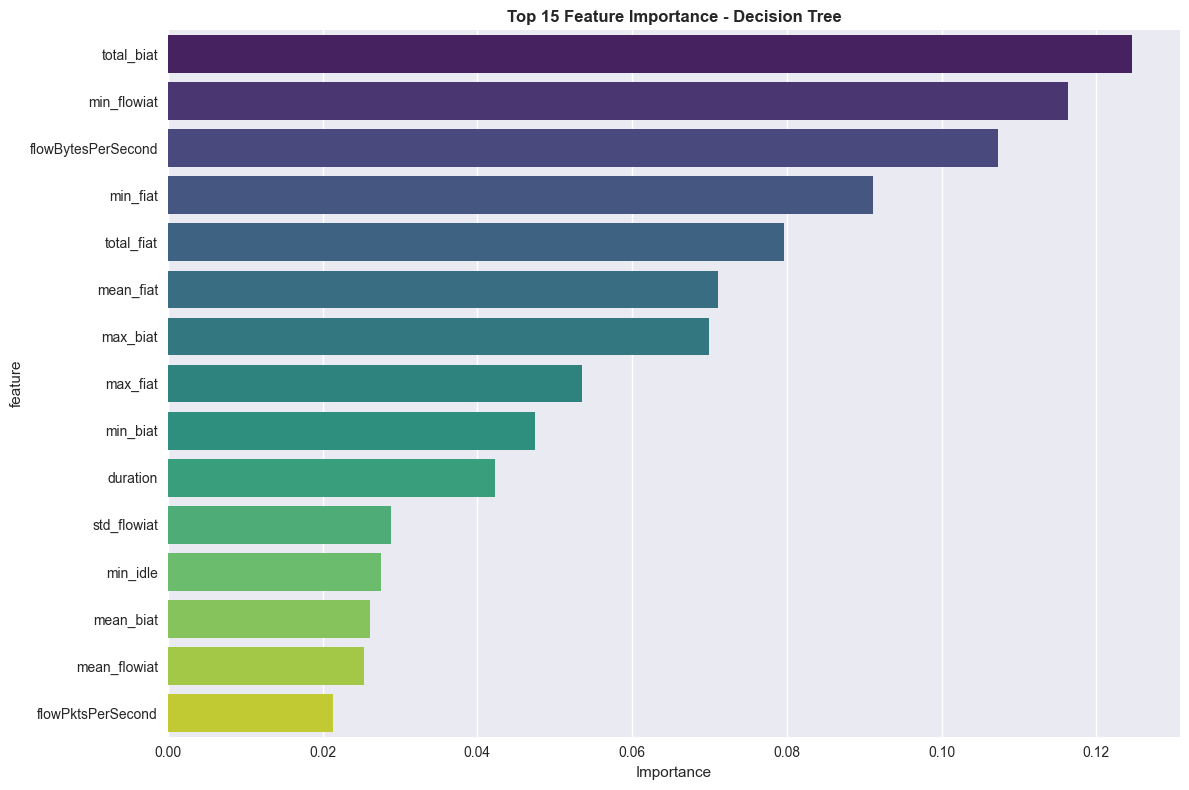

🔍 Top 10 Most Important Features:
           feature  importance
        total_biat    0.124571
       min_flowiat    0.116380
flowBytesPerSecond    0.107322
          min_fiat    0.091127
        total_fiat    0.079579
         mean_fiat    0.071085
          max_biat    0.069977
          max_fiat    0.053581
          min_biat    0.047398
          duration    0.042252


In [80]:
# Feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title(f'Top 15 Feature Importance - {best_model_name}', fontweight='bold')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("🔍 Top 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
else:
    print(f"Feature importance not available for {best_model_name}")

## 8. Model Saving

In [81]:
# Create models directory
import os
os.makedirs('saved_models', exist_ok=True)

# Save all trained models
print("💾 Saving trained models...")

for name, model in trained_models.items():
    filename = f"saved_models/{name.lower().replace(' ', '_')}_model.joblib"
    joblib.dump(model, filename)
    print(f"  ✅ Saved: {filename}")

# Save preprocessing info and results
metadata = {
    'feature_columns': feature_cols,
    'target_column': 'vpn_flag',
    'model_results': results,
    'best_model': best_model_name,
    'dataset_shape': df.shape,
    'test_size': 0.2,
    'random_state': 42
}

joblib.dump(metadata, 'saved_models/model_metadata.joblib')
print("  ✅ Saved: saved_models/model_metadata.joblib")

# Save results as CSV
results_df.to_csv('saved_models/model_comparison_results.csv')
print("  ✅ Saved: saved_models/model_comparison_results.csv")

print("\n🎉 All models and metadata saved successfully!")

💾 Saving trained models...
  ✅ Saved: saved_models/xgboost_model.joblib
  ✅ Saved: saved_models/lightgbm_model.joblib
  ✅ Saved: saved_models/random_forest_model.joblib
  ✅ Saved: saved_models/logistic_regression_model.joblib
  ✅ Saved: saved_models/decision_tree_model.joblib
  ✅ Saved: saved_models/model_metadata.joblib
  ✅ Saved: saved_models/model_comparison_results.csv

🎉 All models and metadata saved successfully!


## 9. Model Loading Example

In [83]:
# Example of how to load and use saved models
print("📂 Loading model example:")

# Load the best model
best_model_filename = f"saved_models/{best_model_name.lower().replace(' ', '_')}_model.joblib"
loaded_model = joblib.load(best_model_filename)

# Load metadata
loaded_metadata = joblib.load('saved_models/model_metadata.joblib')

print(f"✅ Loaded model: {best_model_name}")
print(f"✅ Expected features: {len(loaded_metadata['feature_columns'])}")
print(f"✅ Original accuracy: {loaded_metadata['model_results'][best_model_name]['accuracy']}") 

📂 Loading model example:
✅ Loaded model: Decision Tree
✅ Expected features: 25
✅ Original accuracy: 0.8931502260927818
